# Verifying the dataset samples

This notebook will use the MotionSense view (balanced_20Hz-v1) and will:

1. Apply DFT over dataset windows
2. ...
.
.
.
3. Plot UMAP and T-SNE

In [1]:
import sys
sys.path.append("../..")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from umap import UMAP
#from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from librep.datasets.har.loaders import MotionSense_BalancedView20HZ
from librep.datasets.multimodal import TransformMultiModalDataset, WindowedTransform
from librep.transforms.fft import FFT
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier, SVC, KNeighborsClassifier
from librep.metrics.report import ClassificationReport
from librep.transforms.resampler import SimpleResampler

2022-10-11 12:35:26.799163: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-11 12:35:26.799183: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Load MotionSense, creating PandasMultiModalDatasets with the correct pre-defined windows
loader = MotionSense_BalancedView20HZ("../../data/views/MotionSense/balanced_20Hz-v1", download=False)
train_val, test = loader.load(concat_train_validation=True, label="standard activity code")

In [4]:
train_val.window_names, train_val.window_slices

(['accel-x', 'accel-y', 'accel-z', 'gyro-x', 'gyro-y', 'gyro-z'],
 [(0, 60), (60, 120), (120, 180), (180, 240), (240, 300), (300, 360)])

In [5]:
# Checking the whole data...
train_val[:][0]

array([[-0.10158066, -0.22135512, -0.23401557, ...,  0.29260805,
         0.932535  ,  0.78214699],
       [-0.08252731,  0.20113614, -0.017408  , ...,  0.71842028,
         0.33650671,  0.93656304],
       [ 0.10832292, -0.04594076,  0.01741017, ...,  0.66747733,
        -0.0253858 , -0.03709332],
       ...,
       [ 0.89223938,  0.62981536,  0.39501782, ..., -1.27783961,
        -2.12259886, -1.6891165 ],
       [-0.13631217, -0.46162058, -0.56122841, ...,  1.43220992,
         0.48111957, -2.24206567],
       [ 0.75636407,  0.15959145,  0.5777452 , ..., -2.31604419,
        -1.94461612,  0.71415276]])

In [6]:
train_val[0][0].shape

(360,)

In [7]:
train_val.data

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59,activity code,length,trial_code,index,user,standard activity code
0,-0.101581,-0.221355,-0.234016,-0.264552,-0.200991,-0.208962,-0.308408,0.089943,-0.382516,-0.077553,...,-0.171130,0.292608,0.932535,0.782147,0,150,1,150,11,4
1,-0.082527,0.201136,-0.017408,0.120404,-0.179599,-0.013960,-0.014233,0.253264,0.684288,0.154172,...,0.241819,0.718420,0.336507,0.936563,0,150,1,900,12,4
2,0.108323,-0.045941,0.017410,0.010881,0.019035,-0.157225,0.016889,-0.076276,0.149599,0.016328,...,0.732298,0.667477,-0.025386,-0.037093,0,150,1,1050,21,4
3,-0.370755,-0.495850,0.205895,0.455012,0.113117,-0.327512,0.111760,0.001935,-0.844532,0.440440,...,0.037076,-0.993926,-0.182277,0.317828,0,150,2,150,17,4
4,-0.005683,0.452370,0.028475,0.402016,0.168378,0.353346,0.182684,0.042545,0.001530,-0.009679,...,0.496173,1.265226,1.502311,0.857408,0,150,11,450,21,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4015,-0.007693,0.374393,-0.103716,0.514280,0.141910,0.196481,0.390237,-1.349047,-0.513315,0.040985,...,-0.589413,-1.091889,1.141263,-0.552978,5,150,9,3300,4,5
4016,-0.785497,-0.465941,1.356811,-0.254648,-1.731042,-0.297563,1.190248,-1.193936,0.560628,0.325113,...,2.611230,1.658511,1.304156,-2.120086,5,150,9,150,20,5
4017,0.892239,0.629815,0.395018,-0.061029,0.418810,0.094484,0.048136,-1.074050,0.657432,0.022222,...,1.016603,-1.277840,-2.122599,-1.689117,5,150,9,2550,7,5
4018,-0.136312,-0.461621,-0.561228,-0.670517,0.174832,-0.068340,-0.384419,-0.207647,0.030618,-0.006123,...,1.358415,1.432210,0.481120,-2.242066,5,150,9,2250,7,5


In [8]:
train_val.data.describe()

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59,activity code,length,trial_code,index,user,standard activity code
count,4020.000000,4020.000000,4020.000000,4020.000000,4020.000000,4020.000000,4020.000000,4020.000000,4020.000000,4020.000000,...,4020.000000,4020.000000,4020.000000,4020.000000,4020.000000,4020.0,4020.000000,4020.000000,4020.000000,4020.000000
mean,0.009569,0.001425,0.000187,0.003241,0.010069,0.012288,0.006408,0.001217,-0.000018,0.005076,...,0.034253,0.011783,0.012549,0.019792,2.500000,150.0,7.222139,2352.798507,11.789552,2.500000
std,0.314131,0.335927,0.357080,0.357860,0.343867,0.330574,0.339712,0.349633,0.361537,0.353130,...,0.895659,0.908122,0.906060,0.958959,1.708038,0.0,4.164705,2203.005029,6.687865,1.708038
min,-2.064938,-2.134526,-2.465975,-2.218554,-1.842463,-1.733224,-2.133284,-2.796553,-2.941472,-2.251046,...,-4.615716,-4.485726,-4.728948,-5.142084,0.000000,150.0,1.000000,0.000000,1.000000,0.000000
25%,-0.075914,-0.088001,-0.093494,-0.092736,-0.087128,-0.085257,-0.083864,-0.088367,-0.096246,-0.084432,...,-0.252415,-0.267634,-0.232192,-0.284951,1.000000,150.0,4.000000,750.000000,6.000000,1.000000
50%,0.001189,0.001498,0.000663,0.001061,0.000610,0.001368,0.001622,0.000857,0.000572,0.001030,...,0.000231,0.000189,0.000508,0.000010,2.500000,150.0,6.000000,1650.000000,11.000000,2.500000
75%,0.090875,0.103859,0.100019,0.100826,0.099335,0.105909,0.102329,0.097430,0.095778,0.098675,...,0.272136,0.275081,0.270140,0.287545,4.000000,150.0,9.000000,3300.000000,17.000000,4.000000
max,1.761833,2.527557,2.374839,4.784943,2.125651,2.746906,2.469503,2.364735,2.461613,4.720224,...,5.649079,6.047234,5.391985,5.824174,5.000000,150.0,16.000000,11550.000000,23.000000,5.000000


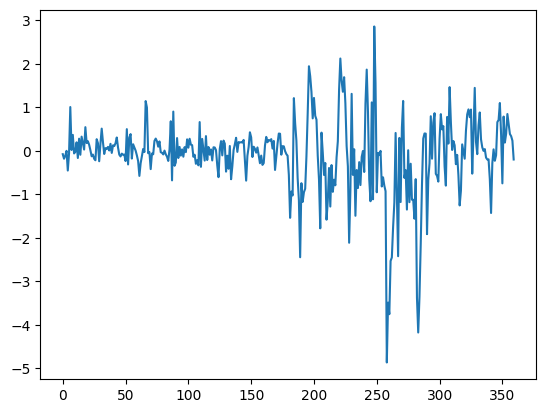

In [9]:
plt.plot(train_val[200][0])

In [10]:
# Create the objects
#scaler_transform = WindowedTransform(
#    transform=train_scaler, fit_on=None, transform_on="all")

fft_transform = FFT(centered=True)

# Compose the transform
# First apply the normalizer over whole dataset and then apply FFT over each window
transformer = TransformMultiModalDataset(
    transforms=[#scaler_transform,
                fft_transform], new_window_name_prefix="scaled."
)

In [11]:
# Transform it and generate a new dataset!
train_val_fft = transformer(train_val)
test_fft = transformer(test)

In [12]:
# Checking the whole data...
train_val_fft[:][0]

array([[5.2349672 , 1.31500631, 0.62294979, ..., 1.51949579, 1.40946664,
        2.67359214],
       [0.4195556 , 1.47781888, 0.7555246 , ..., 3.16244675, 1.15978979,
        1.87787114],
       [2.1285244 , 1.03841388, 0.40157264, ..., 0.31071895, 2.31689217,
        1.23138236],
       ...,
       [1.6130632 , 1.46757266, 1.7738855 , ..., 3.63965033, 1.44604486,
        5.98805148],
       [7.4930136 , 6.47665285, 1.61176447, ..., 2.67894872, 6.28992742,
        3.80509542],
       [0.9599304 , 2.10708733, 0.50065489, ..., 1.44946385, 7.67407215,
        8.59514716]])

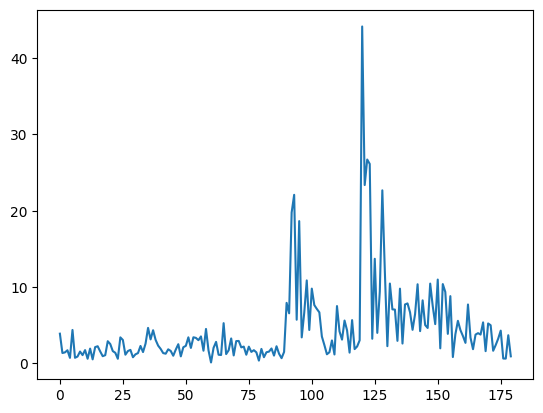

In [13]:
plt.plot(train_val_fft[200][0])

## Classification

Let's take the transformed datasets and train using RandomForest, SVM and KNN 3 times each. Then take the average accuracy and f1-score over the runs

In [14]:
# The reporter will be the same

reporter = ClassificationReport(
    use_accuracy=True,
    use_f1_score=True,
    use_classification_report=True,
    use_confusion_matrix=True,
    plot_confusion_matrix=True
)

### RandomForest (Domínio do Tempo)

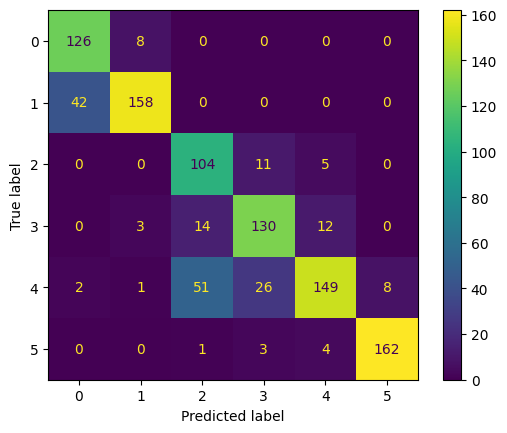

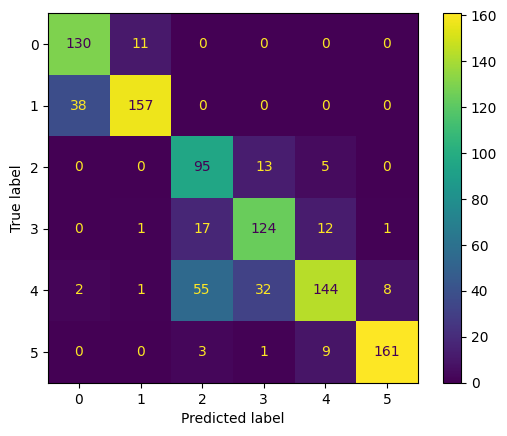

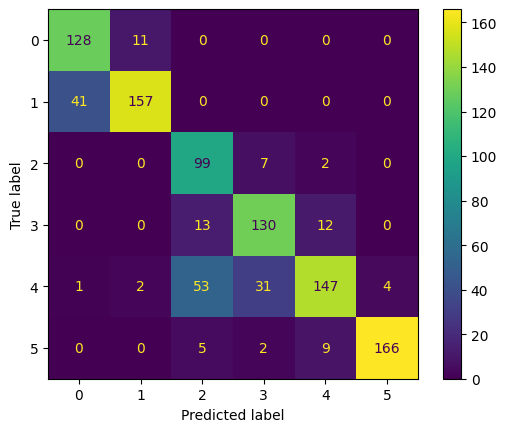

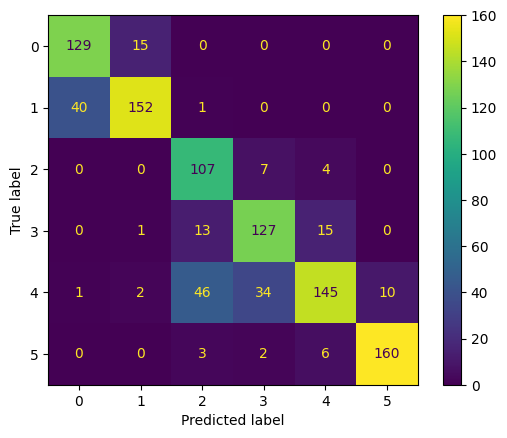

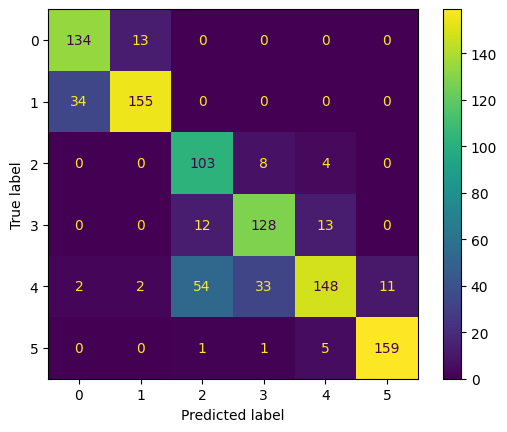

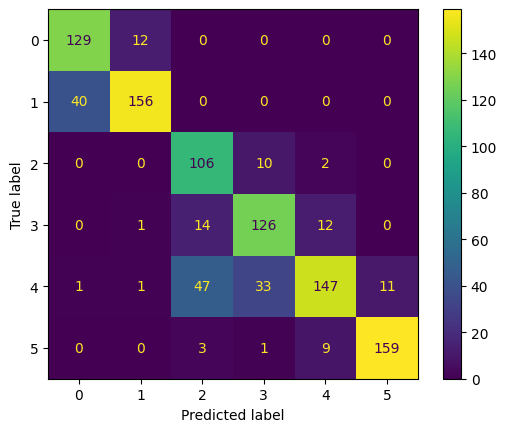

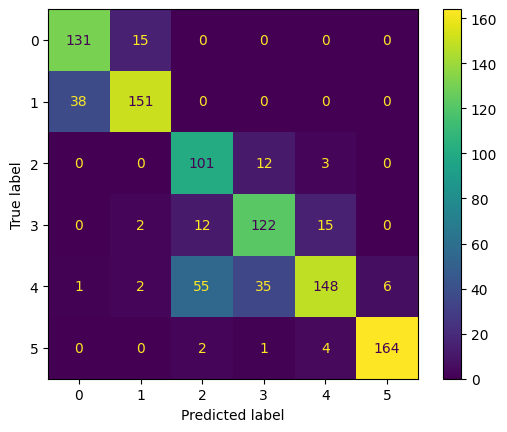

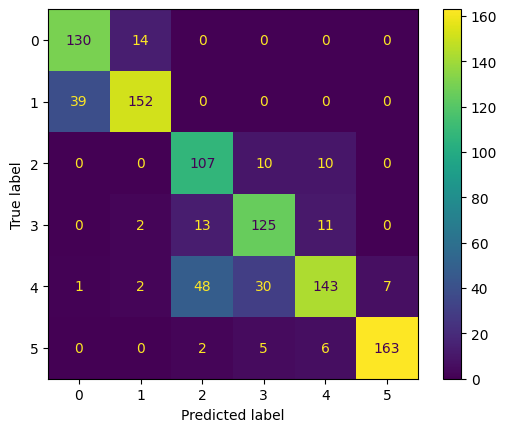

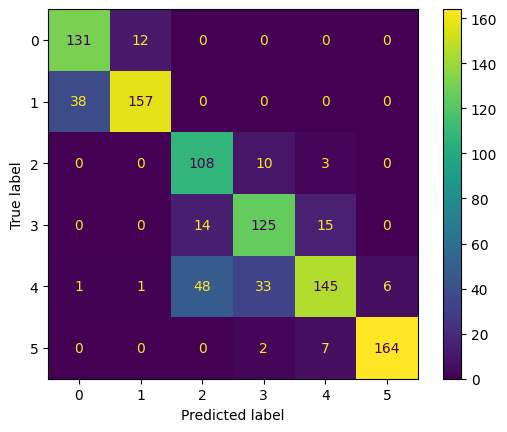

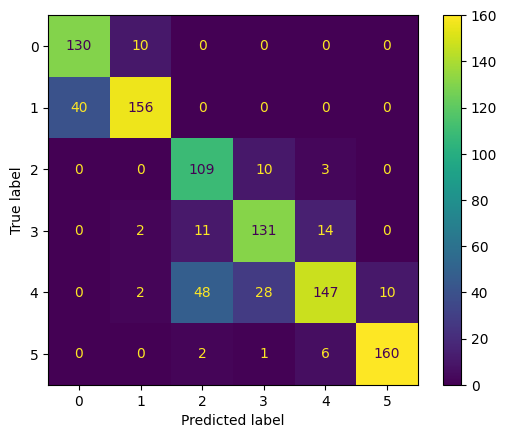

Mean accuracy (10 runs): 0.8075. Mean f1-score: 0.8072
Standard deviation accuracy (10 runs): 0.0063. Standard deviation f1-score: 0.0061


In [15]:
experiment = SimpleTrainEvalWorkflow(
    estimator=RandomForestClassifier,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)
results = multi_run_experiment(train_val, [test])

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
print(f"Mean accuracy (10 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")
print(f"Standard deviation accuracy (10 runs): {std_acc:.4f}. Standard deviation f1-score: {std_f1:.4f}")

### RandomForest (Domínio da Frequência)

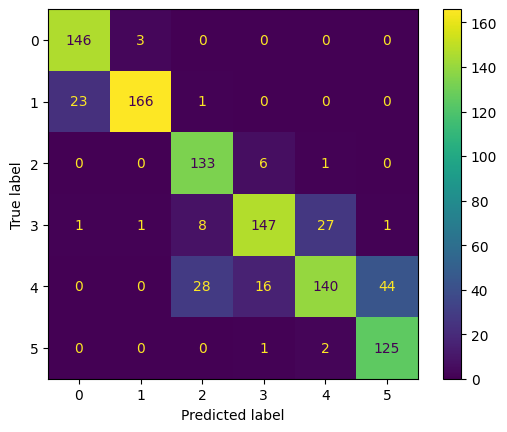

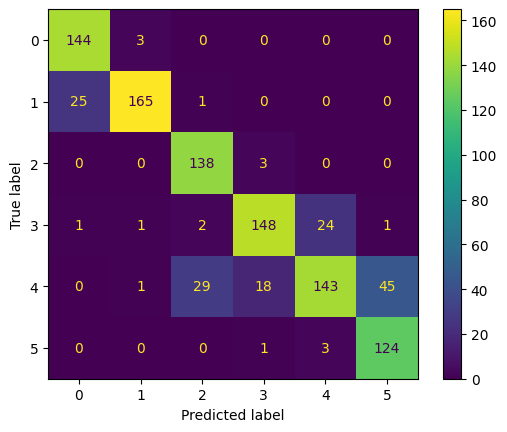

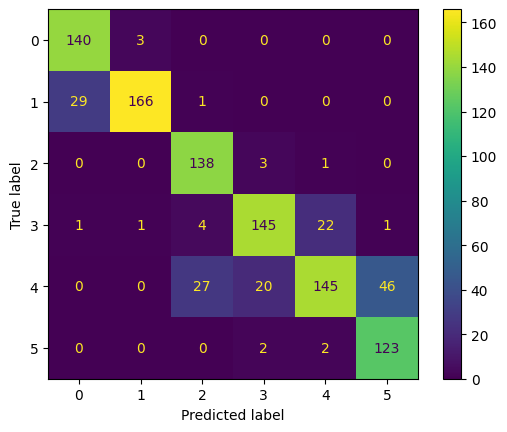

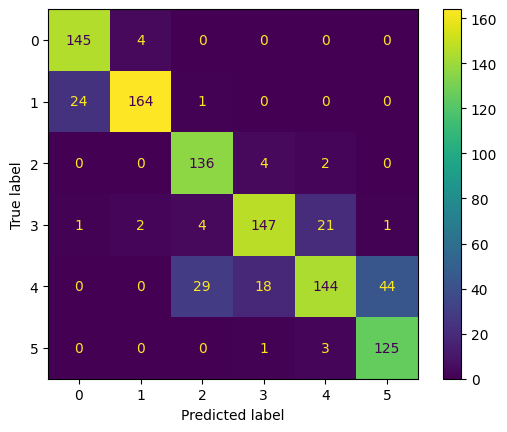

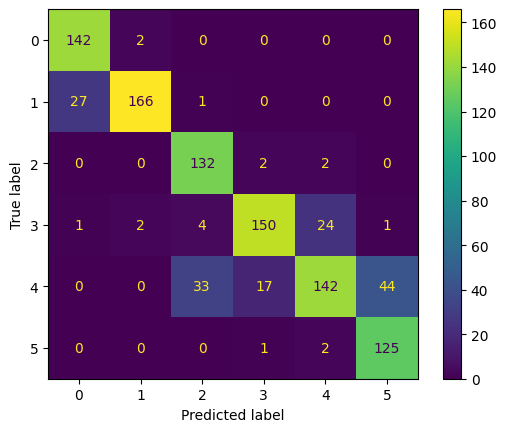

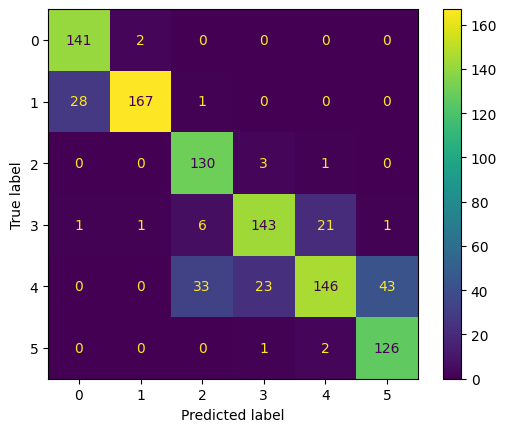

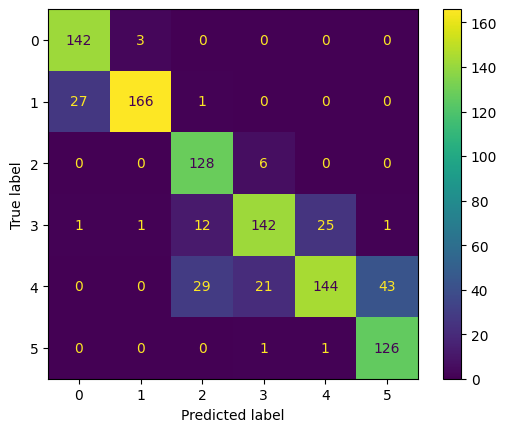

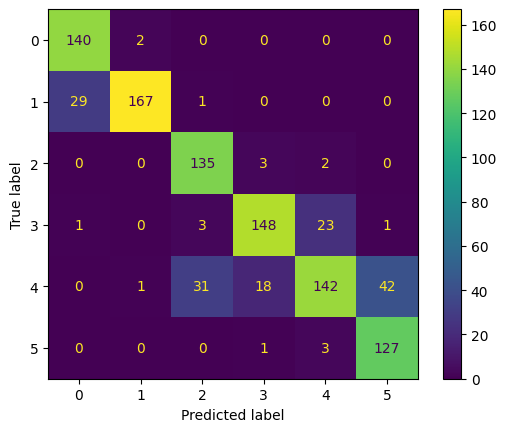

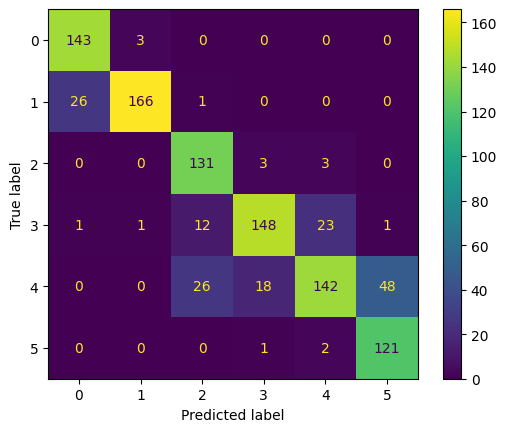

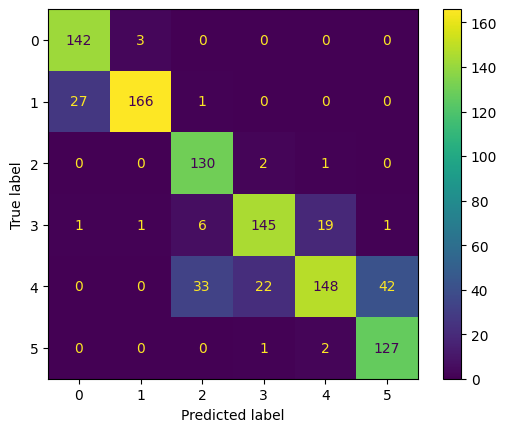

Mean accuracy (10 runs): 0.8395. Mean f1-score: 0.8349
Standard deviation accuracy (10 runs): 0.0041. Standard deviation f1-score: 0.0041


In [16]:
experiment = SimpleTrainEvalWorkflow(
    estimator=RandomForestClassifier,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)
results = multi_run_experiment(train_val_fft, [test_fft])

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
print(f"Mean accuracy (10 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")
print(f"Standard deviation accuracy (10 runs): {std_acc:.4f}. Standard deviation f1-score: {std_f1:.4f}")

### SVM

In [18]:
# experiment = SimpleTrainEvalWorkflow(
#     estimator=SVC,
#     do_not_instantiate=False,
#     do_fit=True,
#     evaluator=reporter,
# )

# multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)
# results = multi_run_experiment(train_val_fft, [test_fft])

# mean_acc = np.average(
#     [res["result"][0]["accuracy"] for res in results["runs"]]
# )
# std_acc = np.std(
#     [res["result"][0]["accuracy"] for res in results["runs"]]
# )
# mean_f1 = np.average(
#     [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
# )
# std_f1 = np.std(
#     [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
# )
# print(f"Mean accuracy (1 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")
# print(f"Standard deviation accuracy (1 runs): {std_acc:.4f}. Standard deviation f1-score: {std_f1:.4f}")

### KNN

In [19]:
# experiment = SimpleTrainEvalWorkflow(
#     estimator=KNeighborsClassifier,
#     do_not_instantiate=False,
#     do_fit=True,
#     evaluator=reporter,
# )

# multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)
# results = multi_run_experiment(train_val_fft, [test_fft])

# mean_acc = np.average(
#     [res["result"][0]["accuracy"] for res in results["runs"]]
# )
# std_acc = np.std(
#     [res["result"][0]["accuracy"] for res in results["runs"]]
# )
# mean_f1 = np.average(
#     [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
# )
# std_f1 = np.std(
#     [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
# )
# print(f"Mean accuracy (1 run): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")
# print(f"Standard deviation accuracy (1 run): {std_acc:.4f}. Standard deviation f1-score: {std_f1:.4f}")

## Plot UMAP and T-SNE

In [20]:
def plot(df, figsize: tuple = (8, 8), title: str = None, labels: dict = None):
    fig, ax = plt.subplots(figsize=figsize)
    for label, group_df in df.groupby("label"):
        label = labels[label] if labels is not None else label
        ax.scatter(group_df.x, group_df.y, label=label)
    ax.legend()
    plt.title(title)
    plt.show()

In [21]:
labels = {0: "Sit", 1: "Stand", 2: "Walk", 3: "Stair up", 4: "Stair down", 5: "Run"}
print(labels)

{0: 'Sit', 1: 'Stand', 2: 'Walk', 3: 'Stair up', 4: 'Stair down', 5: 'Run'}


### UMAP (Domínio do Tempo)

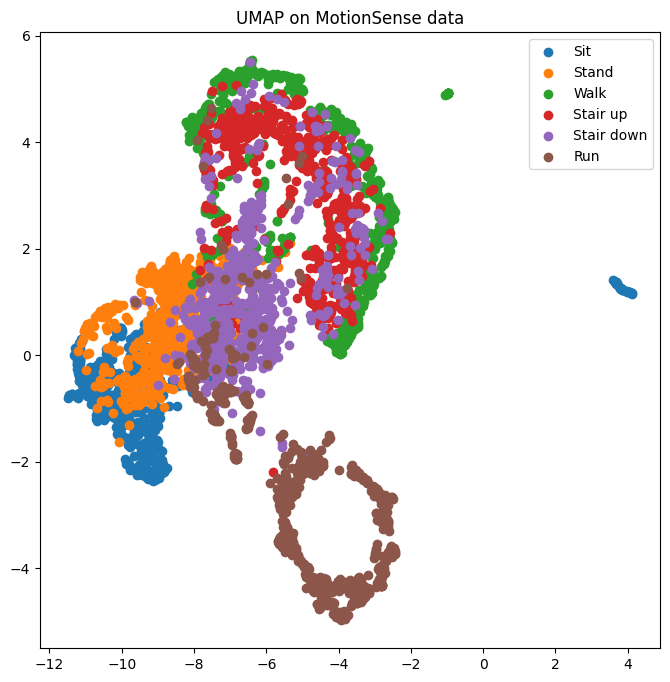

In [25]:
model = UMAP(n_components=2)
result = pd.DataFrame(model.fit_transform(train_val[:][0]), columns=["x", "y"])
result["label"] = train_val[:][1]
plot(result, title="UMAP on MotionSense data", labels = labels)

### T-SNE (Domínio do Tempo)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


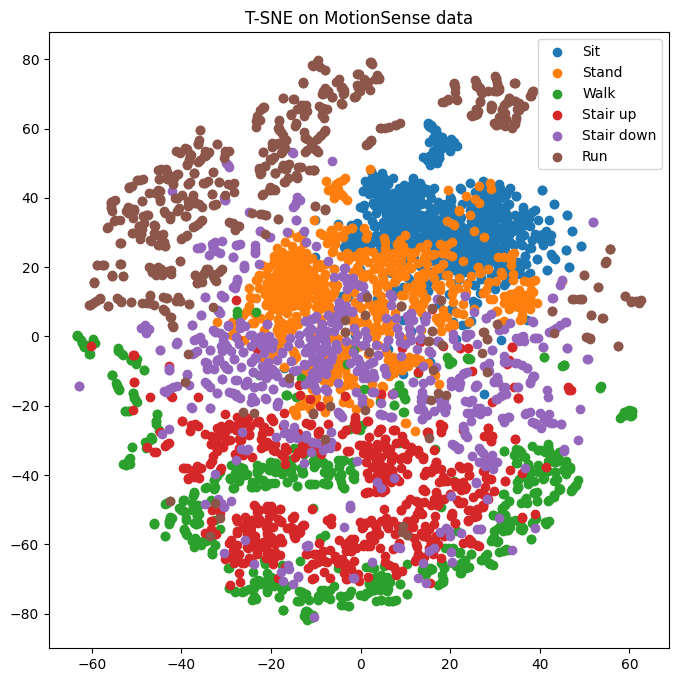

In [26]:
model = TSNE(n_components=2)
result = pd.DataFrame(model.fit_transform(train_val[:][0]), columns=["x", "y"])
result["label"] = train_val[:][1]
plot(result, title="T-SNE on MotionSense data", labels=labels)

### UMAP (Domínio da Frequência)

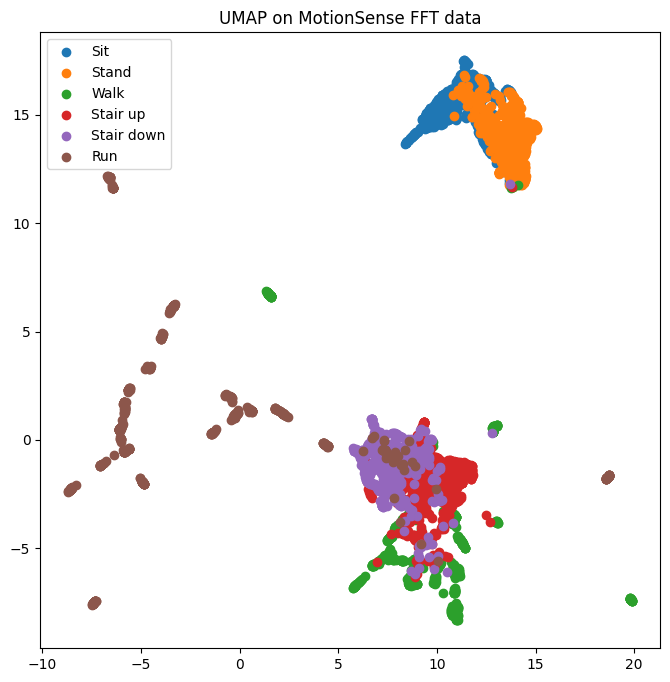

In [27]:
model = UMAP(n_components=2)
result = pd.DataFrame(model.fit_transform(train_val_fft[:][0]), columns=["x", "y"])
result["label"] = train_val_fft[:][1]
plot(result, title="UMAP on MotionSense FFT data", labels = labels)

### T-SNE (Domínio da Frequência)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


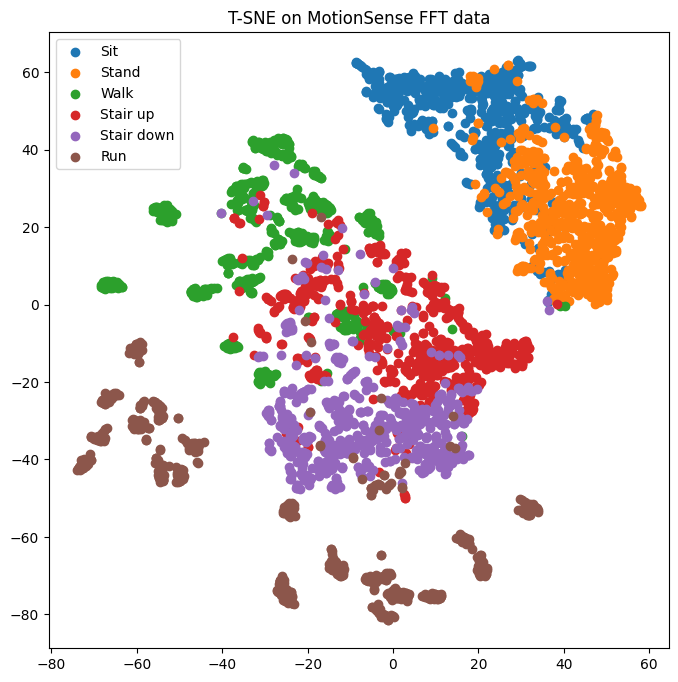

In [28]:
model = TSNE(n_components=2)
result = pd.DataFrame(model.fit_transform(train_val_fft[:][0]), columns=["x", "y"])
result["label"] = train_val_fft[:][1]
plot(result, title="T-SNE on MotionSense FFT data", labels=labels)